In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statistics import mean, stdev

frames = []

for root, dirs, files in os.walk('../data/'):
    for f in files:
        if f.endswith(".csv"):
            file_path = os.path.join(root, f)
            dataframe = pd.read_csv(file_path)
            dataframe.columns=dataframe.columns.str.replace('\t','')
            frames.append(dataframe)

data = pd.concat(frames, sort=False)[['Optimal_Affected_Component', 'Optimal_Failure', 'Optimal_Utility_Increase']]
data.head()

,Optimal_Affected_Component,Optimal_Failure,Optimal_Utility_Increase
0,Query Service,CF1,49.5
1,User Management Service,CF2,16.0
2,Authentication Service,CF3,31.5
3,Bid and Buy Service,CF3,25.0
4,Item Management Service,CF3,16.0


In [2]:
# function for plotting
def plot_data(data_table):
    lists = data_table.groupby(['Optimal_Affected_Component', 'Optimal_Failure'])['Optimal_Utility_Increase'].apply(list).values
    fig = plt.figure(figsize=(50, 5))
    for l in lists:
        plt.hist(l, 75, alpha=0.5)
    plt.show()

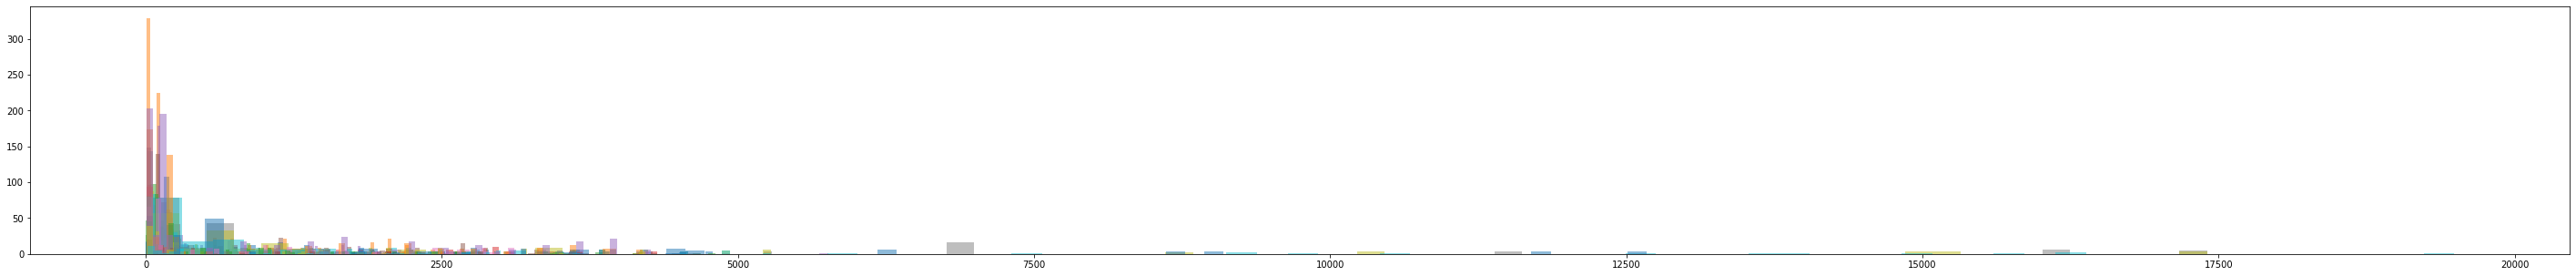

In [3]:
plot_data(data)

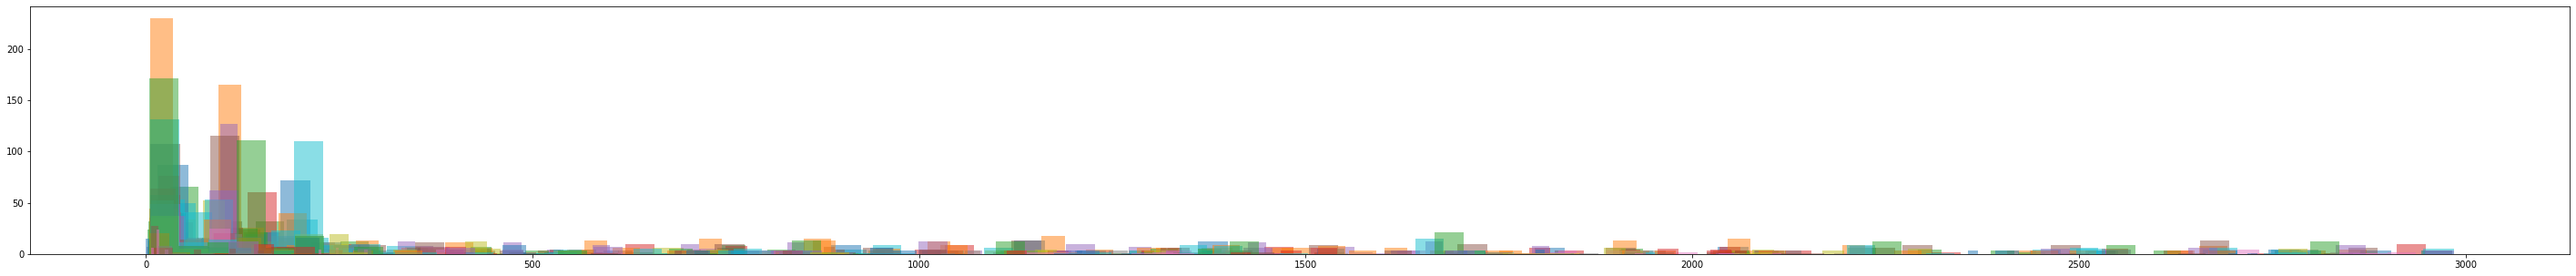

In [4]:
plot_data(data.drop(data[data['Optimal_Utility_Increase'] > 3000].index))

# Data Transformation

## Step 1: Calculate the Standard Deviation and the mean of each <component, failure> combinations

In [5]:
mean_values = data.groupby(['Optimal_Affected_Component', 'Optimal_Failure']).mean()
stdev_values = data.groupby(['Optimal_Affected_Component', 'Optimal_Failure']).std().reset_index()

## Step 2: Sort data by mean values 

In [6]:
mean_values = mean_values.sort_values(by=['Optimal_Utility_Increase'], ascending=True)

## Step 3: Iterate over data and transform it

In [7]:
data_new = data.copy()

previous = None
for name, _ in mean_values.iterrows():
    if previous is not None:
        pre_std = stdev_values.loc[(stdev_values['Optimal_Affected_Component'] == previous[0]) & (stdev_values['Optimal_Failure'] == previous[1])]['Optimal_Utility_Increase'].tolist()[0]
        cur_std = stdev_values.loc[(stdev_values['Optimal_Affected_Component'] == name[0]) & (stdev_values['Optimal_Failure'] == name[1])]['Optimal_Utility_Increase'].tolist()[0]
        data_new.loc[(data_new['Optimal_Affected_Component'] == name[0]) & (data_new['Optimal_Failure'] == name[1]),'Optimal_Utility_Increase'] += cur_std + pre_std
    previous = name
    
data_new.head()

,Optimal_Affected_Component,Optimal_Failure,Optimal_Utility_Increase
0,Query Service,CF1,8710.045827
1,User Management Service,CF2,1726.679529
2,Authentication Service,CF3,2183.394818
3,Bid and Buy Service,CF3,1699.132796
4,Item Management Service,CF3,1001.708713


## Step 4: Analyse Transformation

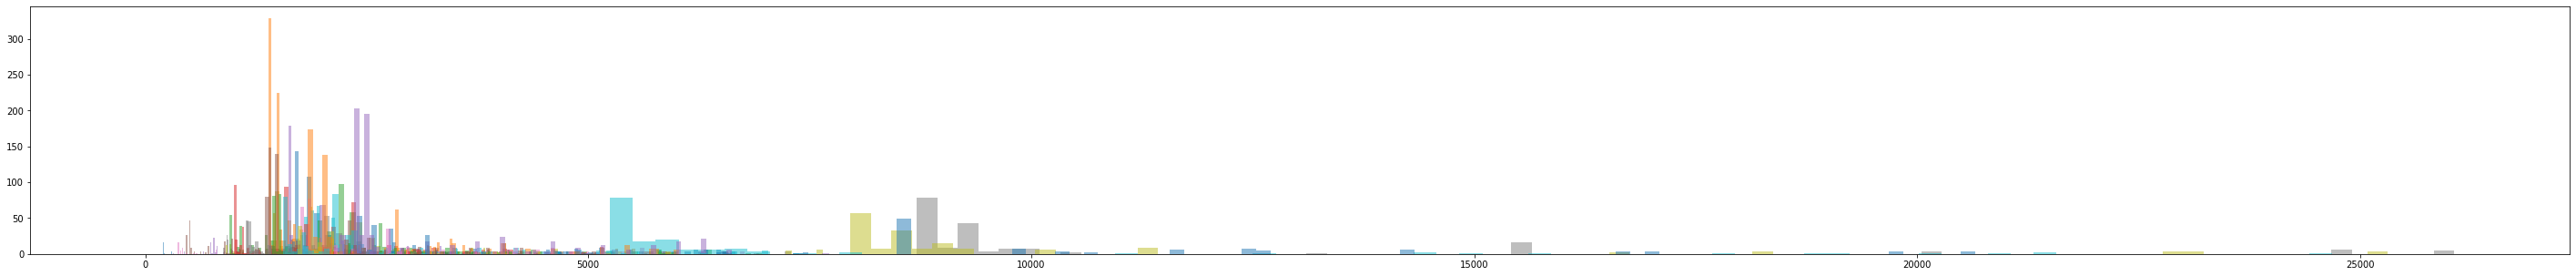

In [8]:
plot_data(data_new)

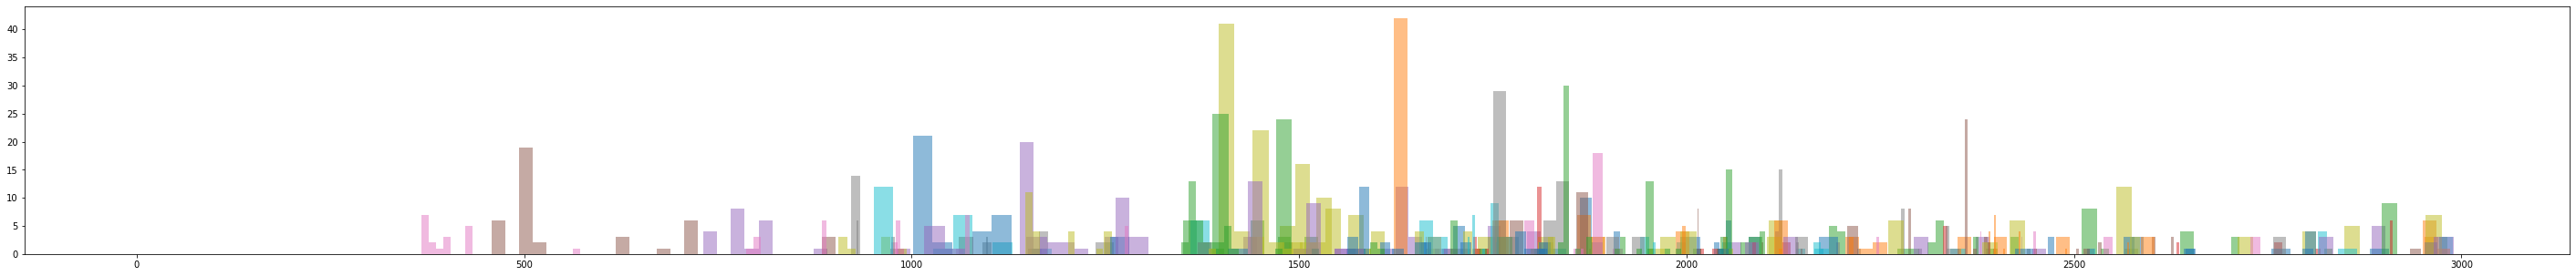

In [9]:
plot_data(data_new.drop(data_new[data_new['Optimal_Utility_Increase'] > 3000].index))

## Step 5: Perform T-Test

In [60]:
ttest_results = pd.DataFrame(columns=['a', 'b', 'statistic', 'pvalue'])

data_new_grouped = data_new.groupby(['Optimal_Affected_Component', 'Optimal_Failure'])['Optimal_Utility_Increase'].apply(list).reset_index()

previous = None
for name, _ in mean_values.iterrows():
    if previous is not None:
        pre = data_new_grouped.loc[(data_new_grouped['Optimal_Affected_Component'] == previous[0]) & (data_new_grouped['Optimal_Failure'] == previous[1])]['Optimal_Utility_Increase'].tolist()[0]
        cur = data_new_grouped.loc[(data_new_grouped['Optimal_Affected_Component'] == name[0]) & (data_new_grouped['Optimal_Failure'] == name[1])]['Optimal_Utility_Increase'].tolist()[0]
        result = stats.ttest_ind(pre, cur)
        new_row = pd.DataFrame({'a': str(previous), 'b': str(name), 'statistic': result[0], 'pvalue': result[1]}, index=[0])
        ttest_results = ttest_results.append(new_row, ignore_index = True)
    previous = name

#ttest_results[ttest_results['statistic']<-0.025][["a", "b", "pvalue"]].to_csv('ttest_results_statisticalSignificant.csv')

# we have at total 70 recombinations
ttest_results[ttest_results['statistic']<-0.025]

,a,b,statistic,pvalue
0,"('Category Item Filter', 'CF1')","('Future Sales Item Filter', 'CF1')",-2.996316,2.412263e-02
1,"('Future Sales Item Filter', 'CF1')","('Comment Item Filter', 'CF1')",-1.296696,2.049590e-01
2,"('Comment Item Filter', 'CF1')","('Availability Item Filter', 'CF3')",-5.192296,1.896310e-06
3,"('Availability Item Filter', 'CF3')","('Recommendation Item Filter', 'CF5')",-0.131775,8.956912e-01
4,"('Recommendation Item Filter', 'CF5')","('Availability Item Filter', 'CF2')",-0.896328,3.716729e-01
5,"('Availability Item Filter', 'CF2')","('Availability Item Filter', 'CF1')",-5.722015,3.759407e-08
6,"('Availability Item Filter', 'CF1')","('Region Item Filter', 'CF1')",-2.226771,2.759499e-02
7,"('Region Item Filter', 'CF1')","('Item Management Service', 'CF3')",-1.631756,1.039186e-01
10,"('Category Item Filter', 'CF2')","('Item Management Service', 'CF2')",-0.993211,3.217447e-01
11,"('Item Management Service', 'CF2')","('Seller Reputation Item Filter', 'CF1')",-0.868713,3.860151e-01
